# Generate RBS Recommendations

This notebook generates RBS recommendations based on the [dataset](https://github.com/synbiochem/opt-mva) provided by [paper](https://pubs.acs.org/doi/abs/10.1021/acssynbio.8b00398). The goal is to find the best 6-base RBS sequence (-6 ~-12 base?) which gives the maximum translation initiation rate (TIR). 

The dataset has 56 arms with 113 data points, which each sequence is 13-base and the label is the TIR. We read the whole data as initialisation and recommend 100 arms to sample in the first round, which will be done in the biology experiment. So the 100 arms should be unique and sampled from the  whole possible arm space. 

In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import itertools
from collections import defaultdict

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB, Random
from codes.evaluations import evaluate, plot_eva
from codes.regression import Regression
from codes.regression_cp import Regression_CP
from codes.kernels import spectrum_kernel
from codes.kernels_pairwise import spectrum_kernel_pw, mixed_spectrum_kernel_pw, WD_kernel_pw, WD_shift_kernel_pw

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

In [3]:
# Data downloaded from https://github.com/synbiochem/opt-mva
# Paper https://pubs.acs.org/doi/abs/10.1021/acssynbio.8b00398

Path = '../data/RBS_list.xlsx'

df = pd.read_excel(Path, sheet_name='Unique RBS')
df.columns = ['A', 'B', 'C', 'D', 'E', 'F']
df.head()

,A,B,C,D,E,F
0,ACGATCTTAAGTAAGCGGGGAAAATAATG,AAGTAAGCGGGGA,57706.0,NaN,AAGTAAGCGGGGA,57706.0
1,ACGATCTTAAGTAGACGCGGAAAATAATG,AAGTAGACGCGGA,613.0,NaN,AAGTAGACGCGGA,613.0
2,ACGATCTTAAGTAAGCGCGGAAAATAATG,AAGTAAGCGCGGA,5313.0,NaN,AAGTAAGCGCGGA,5313.0
3,ACGATCTTAAGTAAACGAGGAAAATAATG,AAGTAAACGAGGA,19594.0,NaN,AAGTAAACGAGGA,19594.0
4,ACGATCTTAAGTAGGCGAGGAAAATAATG,AAGTAGGCGAGGA,33626.0,NaN,AAGTAGGCGAGGA,33626.0


In [4]:
group_one = df[:158].drop_duplicates(subset =['A', 'C'])
group_two = df[158:].drop_duplicates(subset =['A', 'C'])

print('group one length: ', len(group_one))
print('group two length: ', len(group_two))

group one length:  57
group two length:  56


In [5]:
Log_flag = False # indicates whether take log label
Norm_method = 'minmax' # indicates how to normalize label (one of 'mean', 'minmax', None)

def normalize(df):
    # take log FC -- possiblely provide Gaussain distribution?
    if Log_flag:
        df['C'] = np.log(df['C'])
    if Norm_method == 'mean':
        # mean normalization
        df['C'] = (df['C'] - df['C'].mean())/df['C'].std()
    elif Norm_method == 'minmax':
        # min-max normalization 
        df['C'] = (df['C'] - df['C'].min())/(df['C'].max() - df['C'].min())
    else:
        assert Norm_method == None
        
    return df

In [6]:
data_one = np.asarray(normalize(group_one)[['A', 'C']])
data_two = np.asarray(normalize(group_two)[['A', 'C']])

In [7]:
# indicates whether cross validation (KFOLD)
cross_val_flag = False 

# indicates whether plot predict_label vs. true label
plot_flag = True 

# string kernel list 
kernels = [spectrum_kernel_pw, mixed_spectrum_kernel_pw, WD_kernel_pw, 
           #WD_shift_kernel_pw
          ]

# name dictionaries
regression_name = {KernelRidge: 'KR',
                  GaussianProcessRegressor: 'GPR'}

embedding_name = ['onehot', 'kmer', 'label']

str_kernel_name = {
                       spectrum_kernel_pw: 'spec',
                       mixed_spectrum_kernel_pw: 'mspec',
                       WD_kernel_pw: 'WD',
                       WD_shift_kernel_pw: 'WDshift'
                      }

## Train Group One, Test Group Two

In [8]:
train_scores_tro_tew = {}
test_scores_tro_tew = {}

Model:  KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
            kernel=DotProduct(sigma_0=1), kernel_params=None)
Train RMSE:  0.23483097522323895
Test RMSE:  0.24144152759144036


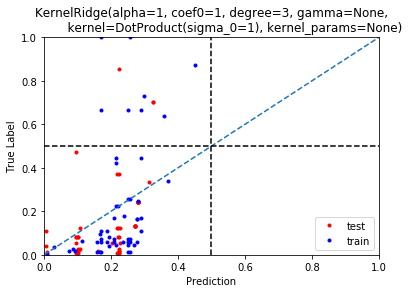

In [9]:
# Baseline: onehot embedding with DotProduct kernel

reg = Regression_CP(KernelRidge(kernel = DotProduct()), data_one, data_two, 'onehot')
reg.train()
train_score, test_score = reg.evaluate(cross_val_flag = cross_val_flag)
train_scores_tro_tew['KR_onehot_DP'] = train_score
test_scores_tro_tew['KR_onehot_DP'] = test_score

Model:  KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
            kernel=<function spectrum_kernel_pw at 0x7f31d3d47598>,
            kernel_params=None)
Train RMSE:  0.22934936286642438
Test RMSE:  0.2301029533409726

Model:  KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
            kernel=<function mixed_spectrum_kernel_pw at 0x7f31d3d47620>,
            kernel_params=None)
Train RMSE:  0.23135477794719245
Test RMSE:  0.2397514045455056

Model:  KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
            kernel=<function WD_kernel_pw at 0x7f31d3d476a8>,
            kernel_params=None)
Train RMSE:  0.21041615958781093
Test RMSE:  0.27959581570430037

Model:  GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=PairwiseKernel(gamma=1.0, metric=<function spectrum_kernel_pw at 0x7f31d3d47598>),
                         n_restarts_optimizer=0, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=None)
Train

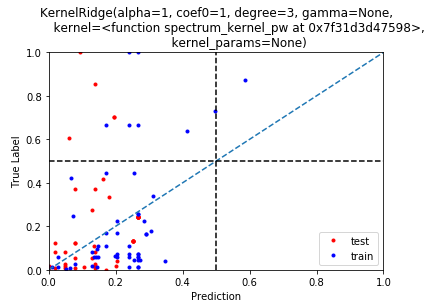

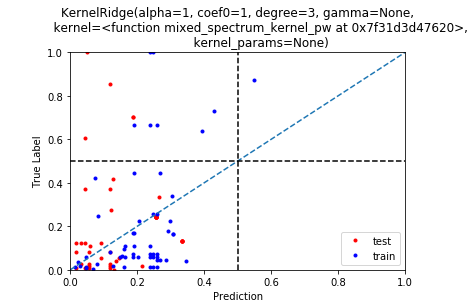

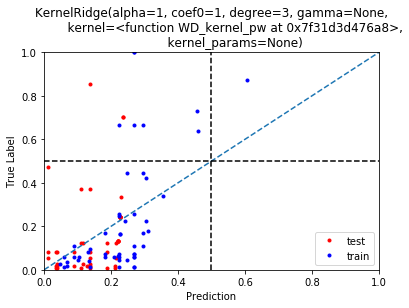

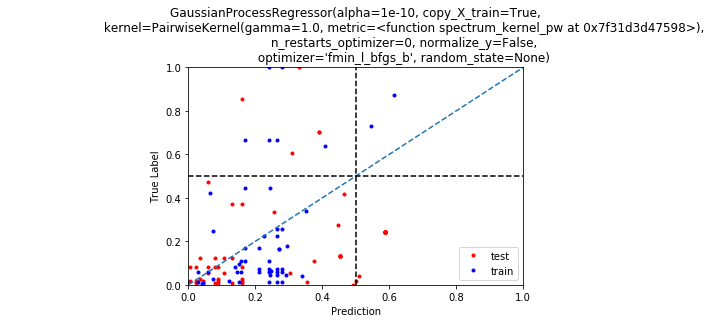

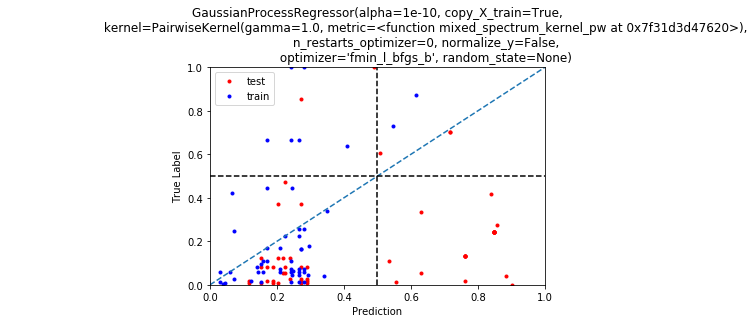

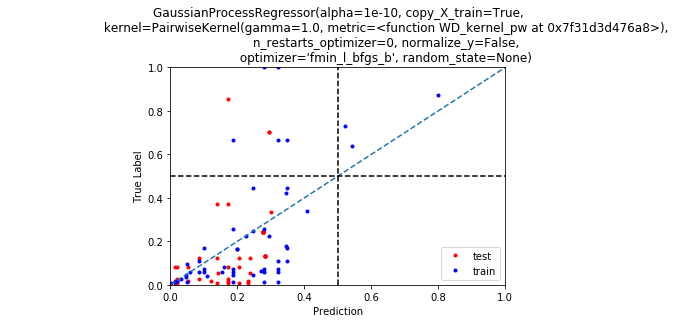

In [10]:
def run_regression(model, kernel, embedding):
    if model == KernelRidge:
        reg = Regression_CP(model(kernel = kernel), data_one, data_two, embedding)
    elif model == GaussianProcessRegressor:
        reg = Regression_CP(model(kernel = PairwiseKernel(metric = kernel)), data_one, data_two, embedding)
    reg.train()
    train_score, test_score = reg.evaluate(cross_val_flag = cross_val_flag, plot_flag = plot_flag)
    key = regression_name[model] + '_' + kernel_name[kernel] + '_' + embedding
    train_scores_tro_tew[key] = train_score
    test_scores_tro_tew[key] = test_score
    print()

for model in [KernelRidge, GaussianProcessRegressor]:
    for kernel in kernels:
        run_regression(model, kernel, 'label')

## Train Group Two, Test Group One

In [11]:
train_scores_trw_teo = {}
test_scores_trw_teo = {}

Model:  KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
            kernel=DotProduct(sigma_0=1), kernel_params=None)
Train RMSE:  0.14690977473340097
Test RMSE:  0.30798696192228064


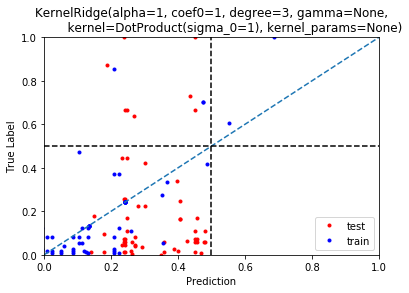

In [12]:
# Baseline: onehot embedding with DotProduct kernel

reg = Regression_CP(KernelRidge(kernel = DotProduct()), data_two, data_one, 'onehot')
reg.train()
train_score, test_score = reg.evaluate(cross_val_flag = cross_val_flag)
train_scores_trw_teo['KR_onehot_DP'] = train_score
test_scores_trw_teo['KR_onehot_DP'] = test_score

Model:  KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
            kernel=<function spectrum_kernel_pw at 0x7f31d3d47598>,
            kernel_params=None)
Train RMSE:  0.13706288123072688
Test RMSE:  0.38393205558426385

Model:  KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
            kernel=<function mixed_spectrum_kernel_pw at 0x7f31d3d47620>,
            kernel_params=None)
Train RMSE:  0.14259766089574905
Test RMSE:  0.4177893322503836

Model:  KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
            kernel=<function WD_kernel_pw at 0x7f31d3d476a8>,
            kernel_params=None)
Train RMSE:  0.1375206922102924
Test RMSE:  0.28348592100598835

Model:  GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=PairwiseKernel(gamma=1.0, metric=<function spectrum_kernel_pw at 0x7f31d3d47598>),
                         n_restarts_optimizer=0, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=None)
Train

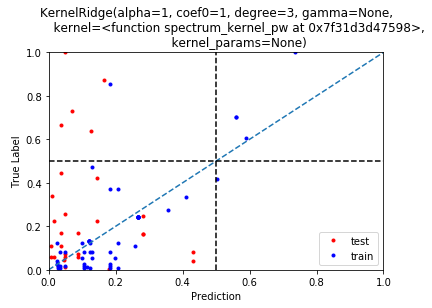

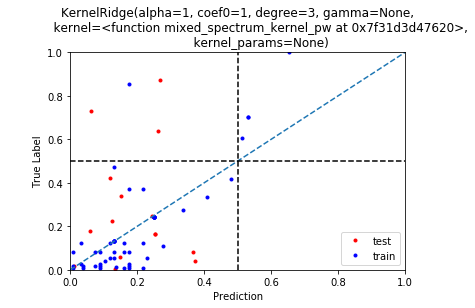

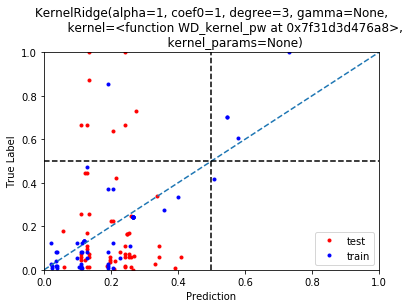

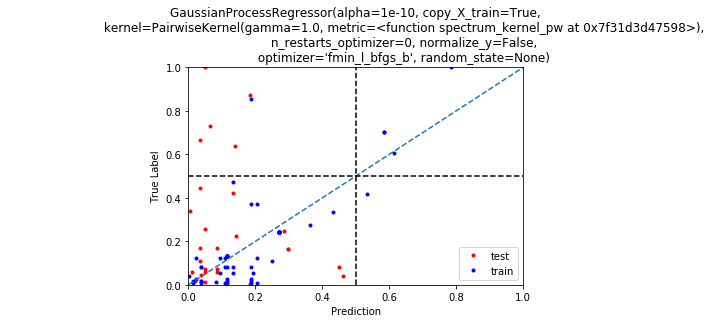

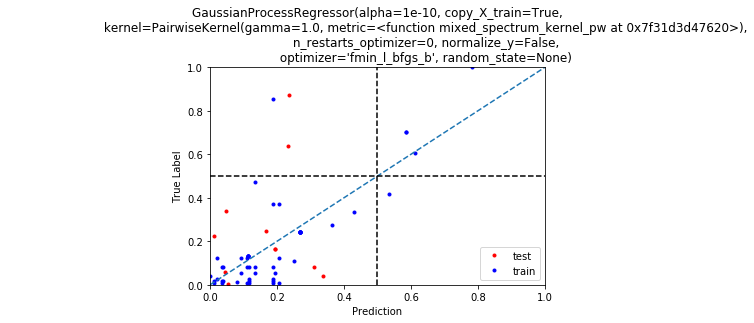

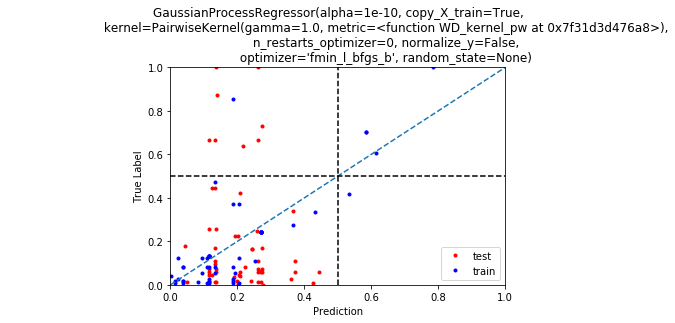

In [13]:
def run_regression(model, kernel, embedding):
    if model == KernelRidge:
        reg = Regression_CP(model(kernel = kernel), data_two, data_one, embedding)
    elif model == GaussianProcessRegressor:
        reg = Regression_CP(model(kernel = PairwiseKernel(metric = kernel)), data_two, data_one, embedding)
    reg.train()
    train_score, test_score = reg.evaluate(cross_val_flag = cross_val_flag, plot_flag = plot_flag)
    key = regression_name[model] + '_' + kernel_name[kernel] + '_' + embedding
    train_scores_trw_teo[key] = train_score
    test_scores_trw_teo[key] = test_score
    print()

for model in [KernelRidge, GaussianProcessRegressor]:
    for kernel in kernels:
        run_regression(model, kernel, 'label')

## Regression for Group One

In [14]:
train_scores_one = {}
test_scores_one = {}

Model:  KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
            kernel=DotProduct(sigma_0=1), kernel_params=None)
Train RMSE:  0.23278967290896024
Test RMSE:  0.2737173549923814


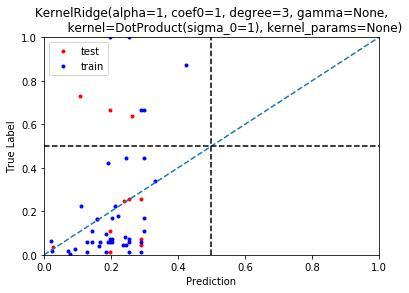

In [15]:
# Baseline: onehot embedding with DotProduct kernel

reg = Regression(KernelRidge(kernel = DotProduct()), data_one, 'onehot')
reg.train()
train_score, test_score = reg.evaluate(cross_val_flag = cross_val_flag)
train_scores_one['KR_onehot_DP'] = train_score
test_scores_one['KR_onehot_DP'] = test_score

Model:  KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
            kernel=<function spectrum_kernel_pw at 0x7f31d3d47598>,
            kernel_params=None)
Train RMSE:  0.23192545637973852
Test RMSE:  0.25265701787016126

Model:  KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
            kernel=<function mixed_spectrum_kernel_pw at 0x7f31d3d47620>,
            kernel_params=None)
Train RMSE:  0.23399718873277858
Test RMSE:  0.2512518301632511

Model:  KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
            kernel=<function WD_kernel_pw at 0x7f31d3d476a8>,
            kernel_params=None)
Train RMSE:  0.21306421935582714
Test RMSE:  0.26132077963041794

Model:  GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=PairwiseKernel(gamma=1.0, metric=<function spectrum_kernel_pw at 0x7f31d3d47598>),
                         n_restarts_optimizer=0, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=None)
Trai

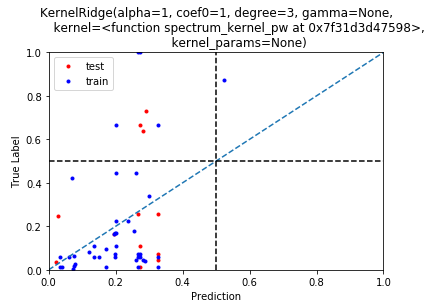

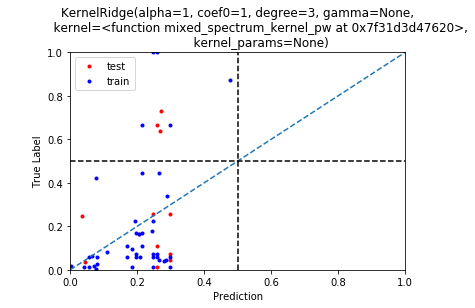

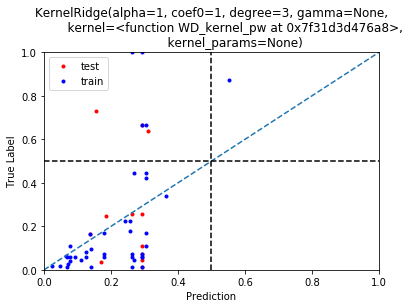

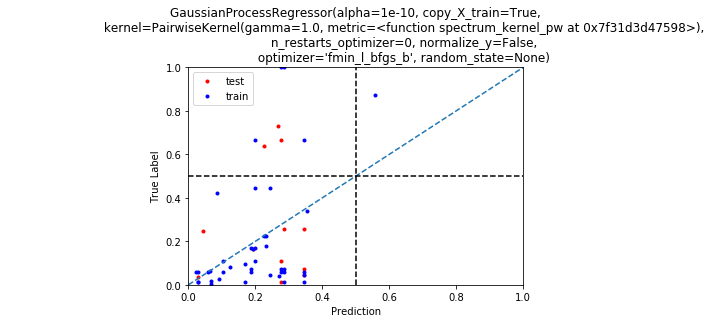

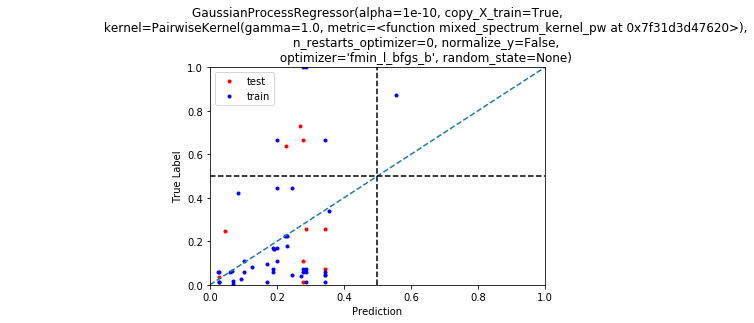

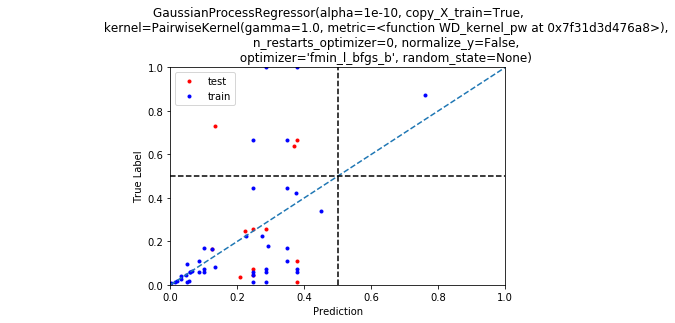

In [16]:
def run_regression(model, kernel, embedding):
    if model == KernelRidge:
        reg = Regression(model(kernel = kernel), data_one, embedding)
    elif model == GaussianProcessRegressor:
        reg = Regression(model(kernel = PairwiseKernel(metric = kernel)), data_one, embedding)
    reg.train()
    train_score, test_score = reg.evaluate(cross_val_flag = cross_val_flag, plot_flag = plot_flag)
    key = regression_name[model] + '_' + kernel_name[kernel] + '_' + embedding
    train_scores_trw_teo[key] = train_score
    test_scores_trw_teo[key] = test_score
    print()

for model in [KernelRidge, GaussianProcessRegressor]:
    for kernel in kernels:
        run_regression(model, kernel, 'label')

## Regression for Group Two

In [17]:
train_scores_two = {}
test_scores_two = {}

Model:  KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
            kernel=DotProduct(sigma_0=1), kernel_params=None)
Train RMSE:  0.15617211884490792
Test RMSE:  0.10888090120436832


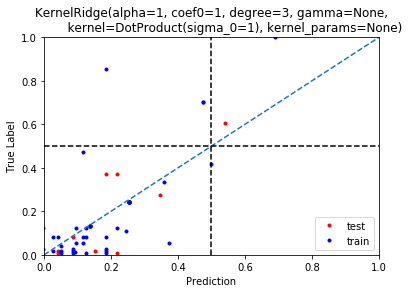

In [18]:
# Baseline: onehot embedding with DotProduct kernel

reg = Regression(KernelRidge(kernel = DotProduct()), data_two, 'onehot')
reg.train()
train_score, test_score = reg.evaluate(cross_val_flag = cross_val_flag)
train_scores_two['KR_onehot_DP'] = train_score
test_scores_two['KR_onehot_DP'] = test_score

Model:  KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
            kernel=<function spectrum_kernel_pw at 0x7f31d3d47598>,
            kernel_params=None)
Train RMSE:  0.13963261494257592
Test RMSE:  0.13021913132380636

Model:  KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
            kernel=<function mixed_spectrum_kernel_pw at 0x7f31d3d47620>,
            kernel_params=None)
Train RMSE:  0.1509656752547973
Test RMSE:  0.11171148224742843

Model:  KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
            kernel=<function WD_kernel_pw at 0x7f31d3d476a8>,
            kernel_params=None)
Train RMSE:  0.1415920673231492
Test RMSE:  0.11874747904708292

Model:  GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=PairwiseKernel(gamma=1.0, metric=<function spectrum_kernel_pw at 0x7f31d3d47598>),
                         n_restarts_optimizer=0, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=None)
Train

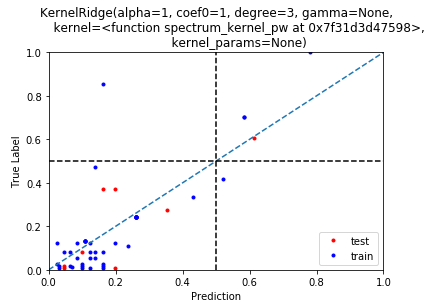

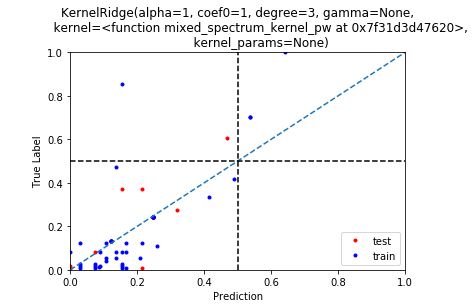

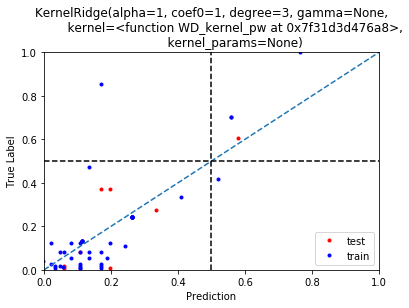

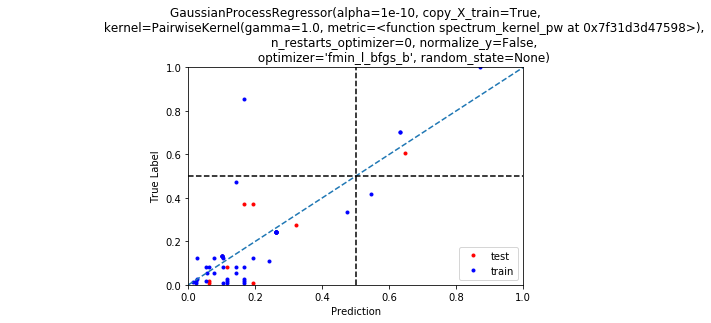

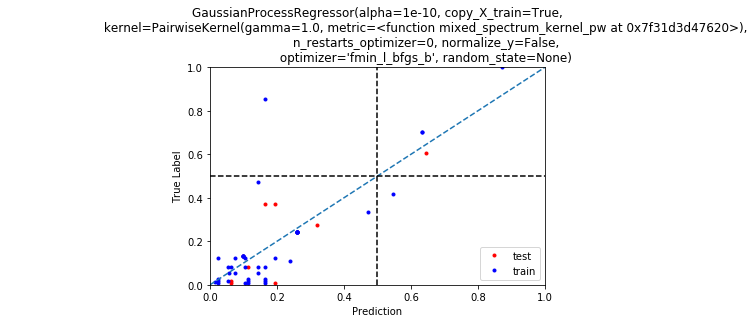

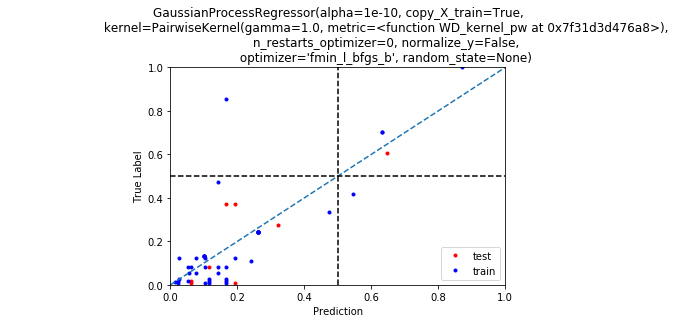

In [19]:
def run_regression(model, kernel, embedding):
    if model == KernelRidge:
        reg = Regression(model(kernel = kernel), data_two, embedding)
    elif model == GaussianProcessRegressor:
        reg = Regression(model(kernel = PairwiseKernel(metric = kernel)), data_two, embedding)
    reg.train()
    train_score, test_score = reg.evaluate(cross_val_flag = cross_val_flag, plot_flag = plot_flag)
    key = regression_name[model] + '_' + kernel_name[kernel] + '_' + embedding
    train_scores_two[key] = train_score
    test_scores_two[key] = test_score
    print()

for model in [KernelRidge, GaussianProcessRegressor]:
    for kernel in kernels:
        run_regression(model, kernel, 'label')

## Compare

Text(0.5, 1.0, 'Test Scores')

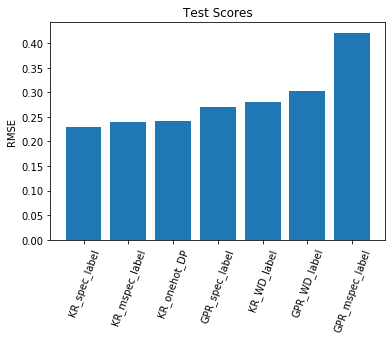

In [20]:
sorted_test_scores = sorted(test_scores_tro_tew.items(), key=lambda kv: kv[1])

import collections

sorted_test_scores = collections.OrderedDict(sorted_test_scores)

plt.bar(range(len(sorted_test_scores)), list(sorted_test_scores.values()), align='center')
plt.xticks(range(len(sorted_test_scores)), list(sorted_test_scores.keys()), rotation = 70)
plt.ylabel('RMSE')
plt.title('Test Scores')

In [21]:
sorted_test_scores = sorted(test_scores_trw_tro.items(), key=lambda kv: kv[1])

import collections

sorted_test_scores = collections.OrderedDict(sorted_test_scores)

plt.bar(range(len(sorted_test_scores)), list(sorted_test_scores.values()), align='center')
plt.xticks(range(len(sorted_test_scores)), list(sorted_test_scores.keys()), rotation = 70)
plt.ylabel('RMSE')
plt.title('Test Scores')

NameError: name 'test_scores_trw_tro' is not defined

In [ ]:
sorted_test_scores = sorted(test_scores_one.items(), key=lambda kv: kv[1])

import collections

sorted_test_scores = collections.OrderedDict(sorted_test_scores)

plt.bar(range(len(sorted_test_scores)), list(sorted_test_scores.values()), align='center')
plt.xticks(range(len(sorted_test_scores)), list(sorted_test_scores.keys()), rotation = 70)
plt.ylabel('RMSE')
plt.title('Test Scores')

In [ ]:
sorted_test_scores = sorted(test_scores_two.items(), key=lambda kv: kv[1])

import collections

sorted_test_scores = collections.OrderedDict(sorted_test_scores)

plt.bar(range(len(sorted_test_scores)), list(sorted_test_scores.values()), align='center')
plt.xticks(range(len(sorted_test_scores)), list(sorted_test_scores.keys()), rotation = 70)
plt.ylabel('RMSE')
plt.title('Test Scores')